<a href="https://colab.research.google.com/github/Zephyrsfisch/NAO-Prediction/blob/main/Model%5CModel_definition_evaluation_winterNAO_Ridge_ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [320]:
#import necessary libraries
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
# Import models you're considering


## Model Selection

Only consider winter NAO (DJF), predicted by autom(SON). We predict the DJF NAO by the previous winter, autom (SON) features and some low frequencie.
For this first a Ridge model is taken (one with only the most important features, the other one with many features), then ARIMAX is used with the reduced number of features.


In [321]:

# Load the NAO daily dataset
url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# Clean and index time
df['time'] = pd.to_datetime(df[['year','month','day']])
df = df.set_index('time')

# Feature Engineering: Seasonality and Decades
# Winter (Nov-Apr) vs Summer (May-Oct)
winter_months = {11, 12, 1, 2, 3, 4}
df['season_flag'] = df['month'].apply(lambda m: 1 if m in winter_months else -1)
df['decade'] = df['year'] // 10 * 10

# Drop redundant columns
df.drop(columns=['day', 'year'], inplace=True)

# Convert to xarray for professional climate data handling
ds = xr.Dataset.from_dataframe(df)

def fill_nans_weighted(ds, dim, n=3):
    """Fills NaNs using a weighted rolling mean (n neighbors)."""
    window = 2 * n + 1
    weights = np.ones(window) / window
    rolled = ds.rolling({dim: window}, center=True).construct("window")
    filled = (rolled * xr.DataArray(weights, dims=["window"])).sum("window")
    return ds.fillna(filled)

ds = fill_nans_weighted(ds, dim='time', n=3)

df = ds.to_dataframe()
df

,month,nao_index_cdas,season_flag,decade
time,,,,
1950-01-01,1.0,0.365000,1.0,1950.0
1950-01-02,1.0,0.096000,1.0,1950.0
1950-01-03,1.0,-0.416000,1.0,1950.0
1950-01-04,1.0,-0.616000,1.0,1950.0
1950-01-05,1.0,-0.261000,1.0,1950.0
...,...,...,...,...
2026-01-06,1.0,-1.017777,1.0,2020.0
2026-01-07,1.0,-0.546581,1.0,2020.0
2026-01-08,1.0,-0.395583,1.0,2020.0


In [322]:
# Resample daily NAO to monthly mean
ds_monthly = ds.resample(time="ME").mean()

# Convert to pandas DataFrame if needed
df_monthly = ds_monthly.to_dataframe()

df_monthly

,month,nao_index_cdas,season_flag,decade
time,,,,
1950-01-31,1.0,0.463516,1.0,1950.0
1950-02-28,2.0,0.420714,1.0,1950.0
1950-03-31,3.0,0.008387,1.0,1950.0
1950-04-30,4.0,0.239433,1.0,1950.0
1950-05-31,5.0,-0.261226,-1.0,1950.0
...,...,...,...,...
2025-09-30,9.0,-0.373873,-1.0,2020.0
2025-10-31,10.0,-0.398225,-1.0,2020.0
2025-11-30,11.0,-0.434436,1.0,2020.0


In [323]:
df = df_monthly.copy()

# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Define winter year: Dec belongs to next year
df["year"] = df.index.year
df["winter_year"] = np.where(df.index.month == 12,
                              df.index.year + 1,
                              df.index.year)

# Keep only DJF months
df_winter_months = df[df.index.month.isin([12, 1, 2])]


In [324]:
# DJF mean NAO (target variable)
winter_nao = (
    df_winter_months
    .groupby("winter_year")["nao_index_cdas"]
    .mean()
    .rename("nao_djf")
)

winter_nao = winter_nao.dropna()


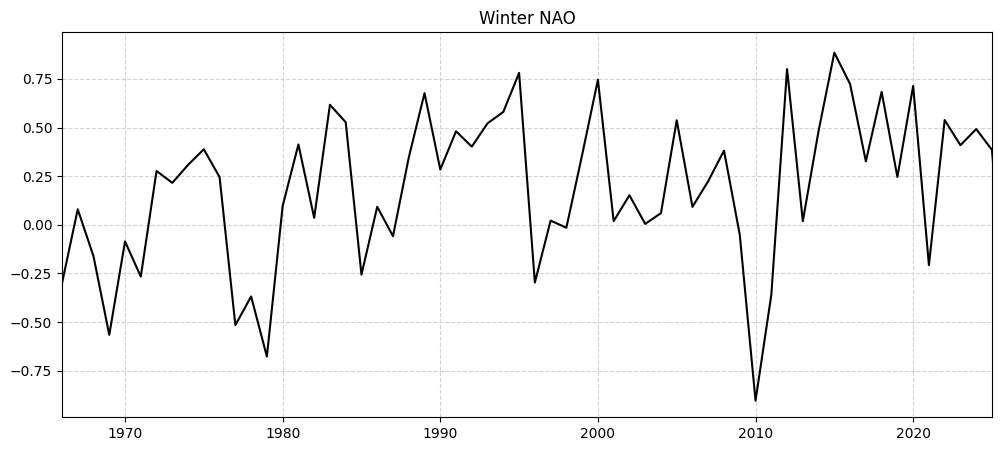

In [325]:
#winter_nao.plot()

plt.figure(figsize=(12, 5))
plt.plot(winter_nao, color="black")
plt.xlim(1966, 2025)
plt.ylim(-0.99,0.99)
#plt.legend()
plt.title("Winter NAO")
plt.grid(linestyle = '--', color = 'lightgrey')
plt.show()

## Feature Engineering: More possible features
son_features,
prev_winter,
lowfreq,
nao_lowfreq_20yr,
neg_extreme,
son_max_persistence,
son_p10

In [326]:
# Select autum (SON) months
df_son = df[df.index.month.isin([9, 10, 11])]

son_features = (
    df_son
    .groupby(df_son.index.year)
    ["nao_index_cdas"]
    .agg(
        son_mean="mean",
        son_std="std",
        son_min="min",
        son_max="max",
    )
)

son_features.index.name = "winter_year"

In [327]:
prev_winter = winter_nao.shift(1).rename("nao_prev_winter")
lowfreq = (
    winter_nao
    .rolling(window=10, center=False, min_periods=5)
    .mean()
    .rename("nao_lowfreq_10yr")
)
# add an even lower freq.
nao_lowfreq_20yr = (
    winter_nao
    .rolling(window=20, min_periods=10)
    .mean()
    .rename("nao_lowfreq_20yr")
)


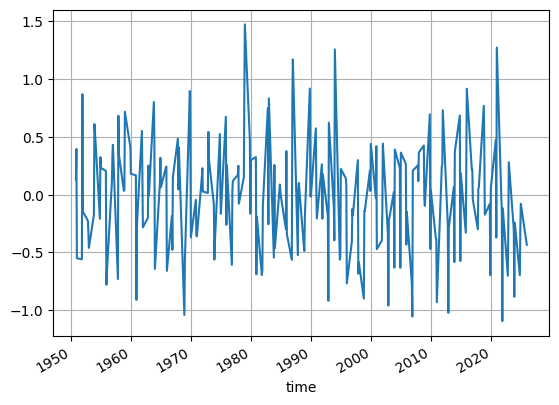

In [328]:
df[df.index.month.isin([9, 10, 11])].nao_index_cdas.plot()
plt.grid()

In [329]:
#Consider negative extremes during autom (son), for that take DAILY values
df_son_daily = df[df.index.month.isin([9, 10, 11])]

neg_extreme = (
    df_son_daily
    .groupby(df_son_daily.index.year)["nao_index_cdas"]
    .apply(lambda x: (x < -1.0).sum())
    .rename("son_days_nao_lt_m1")
)

<Axes: xlabel='time'>

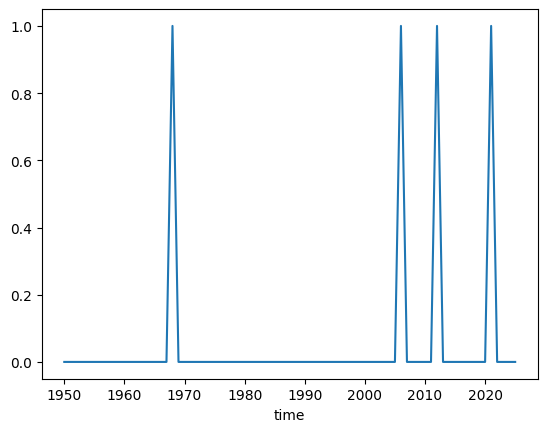

In [330]:
neg_extreme.plot()

<Axes: xlabel='time'>

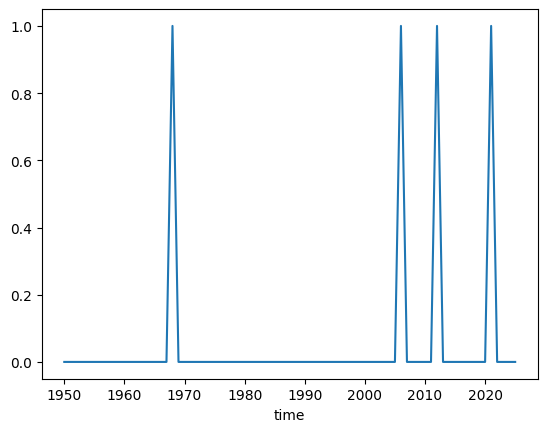

In [331]:
def max_run_length(series, threshold=-1.0):
    mask = series < threshold
    runs = (mask != mask.shift()).cumsum()
    return mask.groupby(runs).sum().max()

son_max_persistence = (
    df_son_daily
    .groupby(df_son_daily.index.year)["nao_index_cdas"]
    .apply(max_run_length)
    .rename("son_max_neg_persistence")
)
son_max_persistence.plot()

<Axes: xlabel='time'>

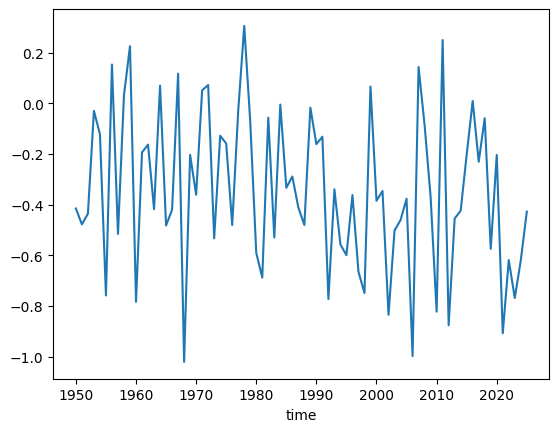

In [332]:
son_p10 = (
    df_son_daily
    .groupby(df_son_daily.index.year)["nao_index_cdas"]
    .quantile(0.10)
    .rename("son_p10")
)
son_p10.plot()

In [333]:
son_features['son_min']

,son_min
winter_year,
1950,-0.551567
1951,-0.560400
1952,-0.461267
1953,-0.175767
1954,-0.209733
...,...
2021,-1.095038
2022,-0.702423
2023,-0.884628


## Implementation of Ridge



In [334]:
X = pd.concat(
    [lowfreq,
    son_features['son_min'],
    prev_winter,
    son_features['son_mean']],#son_features, prev_winter, lowfreq, nao_lowfreq_20yr, neg_extreme,son_p10],#son_max_persistence makes the same as neg_extreme,
    axis=1
)

y = winter_nao

# Align and drop missing years
data = pd.concat([X, y], axis=1).dropna()

X = data.drop(columns="nao_djf")
y = data["nao_djf"]


In [335]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

In [336]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
#Split 1: Train: winters 1951–1975, Test:  winters 1976–1982
#Split 2: Train: winters 1951–1982,Test:  winters 1983–1989
#...

predictions = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    pred_df = pd.DataFrame({
        "y_true": y_test,
        "y_pred": y_pred
    }, index=y_test.index)

    predictions.append(pred_df)

predictions = pd.concat(predictions).sort_index()


## Evaluation Metrics reduced Ridge and Comparative Analysis reduce Ridge

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [337]:
R = predictions["y_true"].corr(predictions["y_pred"])
R2_corr = R**2
print("R² (squared correlation) =", R2_corr)
print("Correlation R =", R)

R² (squared correlation) = 0.15963836475577659
Correlation R = 0.3995477002258636


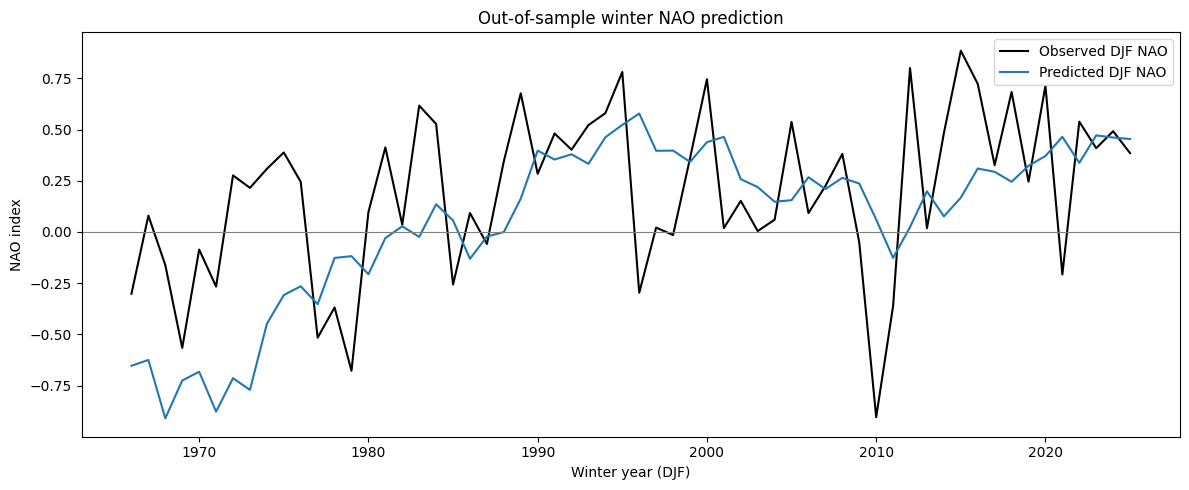

In [338]:
plt.figure(figsize=(12, 5))

plt.plot(predictions.index, predictions["y_true"],
         label="Observed DJF NAO", color="black")

plt.plot(predictions.index, predictions["y_pred"],
         label="Predicted DJF NAO", color="tab:blue")

plt.axhline(0, color="gray", lw=0.8)

plt.xlabel("Winter year (DJF)")
plt.ylabel("NAO index")
plt.title("Out-of-sample winter NAO prediction")
plt.legend()
plt.tight_layout()
plt.show()


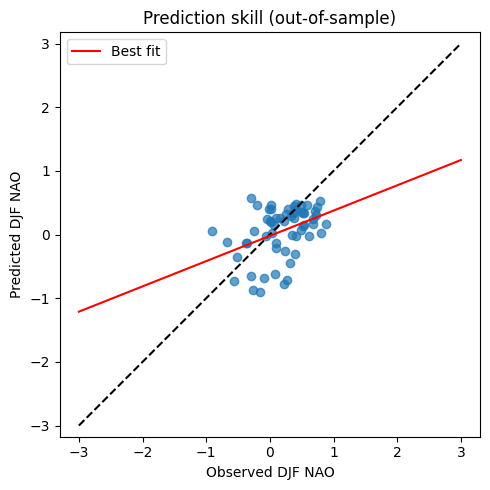

In [339]:
plt.figure(figsize=(5, 5))

plt.scatter(predictions["y_true"], predictions["y_pred"], alpha=0.7)
plt.plot([-3, 3], [-3, 3], "k--")

coef = np.polyfit(predictions["y_true"], predictions["y_pred"], 1)
x = np.linspace(-3, 3, 100)
y = coef[0] * x + coef[1]

plt.plot(x, y, color="red", label="Best fit")
plt.legend()

plt.xlabel("Observed DJF NAO")
plt.ylabel("Predicted DJF NAO")
plt.title("Prediction skill (out-of-sample)")
plt.axis("equal")
plt.tight_layout()
plt.show()


Strong NAO underestimated by prediction.

Upward tilt → some predictability, look in R and R^2

Centered → unbiased forecast
Shifted up/down → mean bias
Flatter than 1:1 → amplitude underestimation (very common)

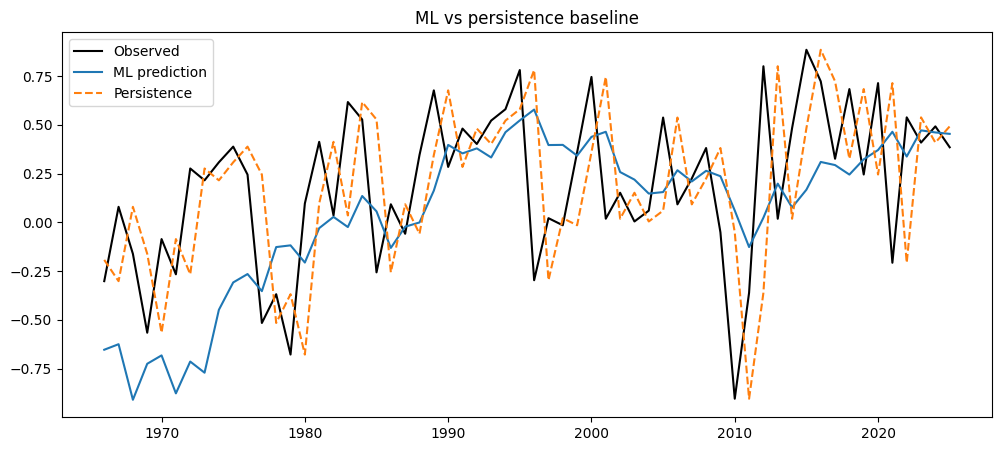

In [340]:
predictions["persistence"] = winter_nao.shift(1).loc[predictions.index]

plt.figure(figsize=(12, 5))
plt.plot(predictions.index, predictions["y_true"], label="Observed", color="black")
plt.plot(predictions.index, predictions["y_pred"], label="ML prediction")
plt.plot(predictions.index, predictions["persistence"], label="Persistence", ls="--")

plt.legend()
plt.title("ML vs persistence baseline")
plt.show()

In [341]:
R_ml = predictions["y_true"].corr(predictions["y_pred"])
R_persist = predictions["y_true"].corr(predictions["persistence"])
print("R² (squared correlation) ML =", R_ml**2)
print("R² (squared correlation) persistence =", R_persist**2)

R² (squared correlation) ML = 0.15963836475577659
R² (squared correlation) persistence = 0.1084178514082077


Persistence= next winter is as the previous one.

R² ML is higher then R² persistenve, so the model is slightly better.

## More features for Ridge
add feature refimes with NAO beeing above or below thresholds.

In [342]:
# classify monthly NAO into regimes
def classify_regime(x):
    if x > 0.5:
        return 1    # NAO+
    elif x < -0.5:
        return -1   # NAO-
    else:
        return 0    # neutral

df["nao_regime"] = df["nao_index_cdas"].apply(classify_regime)


In [343]:
# autumn months
df_son = df[df.index.month.isin([9, 10, 11])]

regime_features = (
    df_son
    .groupby(df_son.index.year)["nao_regime"]
    .agg(
        frac_pos=lambda x: (x == 1).mean(),
        frac_neg=lambda x: (x == -1).mean(),
        frac_neu=lambda x: (x == 0).mean(),
        mean_regime="mean",
    )
)

regime_features.index.name = "winter_year"


In [344]:
X = pd.concat(
    [
        son_features,        # mean, std, min, max
        regime_features,    # NEW
        prev_winter,
        lowfreq,
        nao_lowfreq_20yr,
        neg_extreme,
        #son_max_persistence, #is the same as neg_extreme...
        son_p10
    ],
    axis=1
)

y = winter_nao

data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns="nao_djf")
y = data["nao_djf"]


In [345]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])


In [346]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
#Split 1: Train: winters 1951–1975, Test:  winters 1976–1982
#Split 2: Train: winters 1951–1982,Test:  winters 1983–1989
#...

predictions_regimes = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    pred_regimes_df = pd.DataFrame({
        "y_true": y_test,
        "y_pred": y_pred
    }, index=y_test.index)

    predictions_regimes.append(pred_regimes_df)

predictions_regimes = pd.concat(predictions_regimes).sort_index()


## Evaluation Metrics full Ridge and Comparative Analysis full Ridge

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


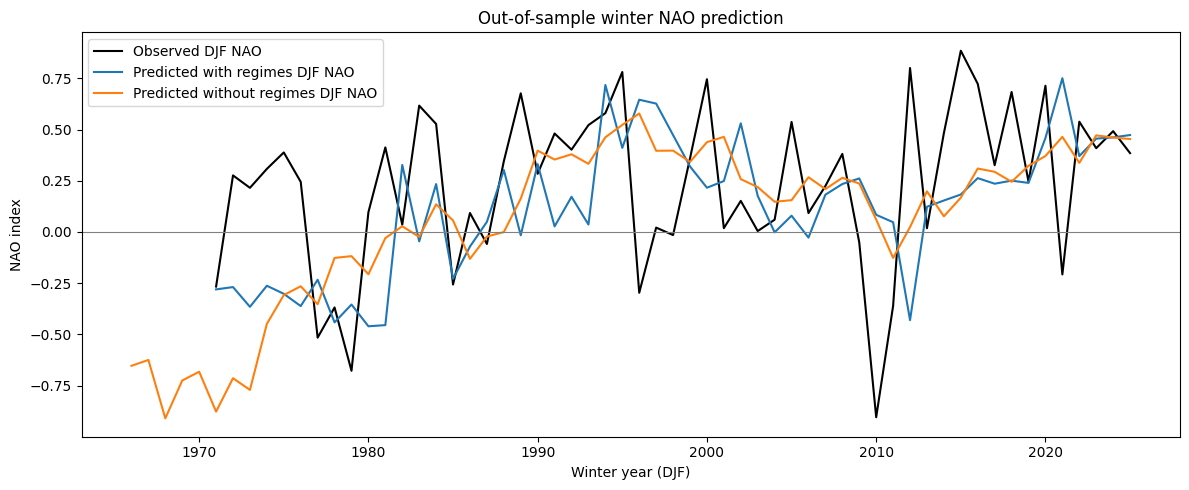

In [347]:
plt.figure(figsize=(12, 5))

plt.plot(predictions_regimes.index, predictions_regimes["y_true"],
         label="Observed DJF NAO", color="black")

plt.plot(predictions_regimes.index, predictions_regimes["y_pred"],
         label="Predicted with regimes DJF NAO", color="tab:blue")

plt.plot(predictions.index, predictions["y_pred"],
         label="Predicted without regimes DJF NAO", color="tab:orange")

plt.axhline(0, color="gray", lw=0.8)

plt.xlabel("Winter year (DJF)")
plt.ylabel("NAO index")
plt.title("Out-of-sample winter NAO prediction")
plt.legend()
plt.tight_layout()
plt.show()


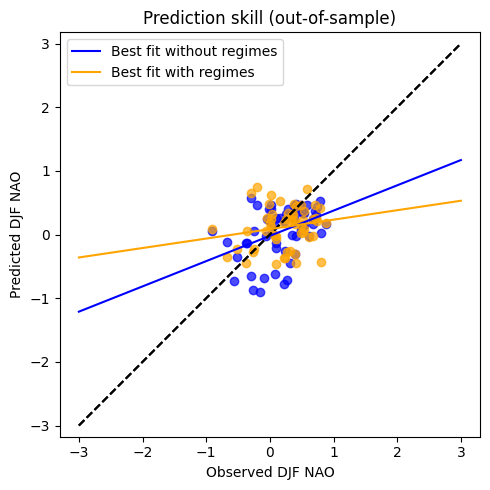

In [348]:
plt.figure(figsize=(5, 5))

plt.scatter(predictions["y_true"], predictions["y_pred"], alpha=0.7, color = "blue")
plt.plot([-3, 3], [-3, 3], "k--")

coef = np.polyfit(predictions["y_true"], predictions["y_pred"], 1)
x = np.linspace(-3, 3, 100)
y = coef[0] * x + coef[1]

plt.plot(x, y, color="blue", label="Best fit without regimes")

#now with the regimes
plt.scatter(predictions_regimes["y_true"], predictions_regimes["y_pred"], alpha=0.7, color="orange")
plt.plot([-3, 3], [-3, 3], "k--")

coef = np.polyfit(predictions_regimes["y_true"], predictions_regimes["y_pred"], 1)
x = np.linspace(-3, 3, 100)
y = coef[0] * x + coef[1]

plt.plot(x, y, color="orange", label="Best fit with regimes")

plt.legend()

plt.xlabel("Observed DJF NAO")
plt.ylabel("Predicted DJF NAO")
plt.title("Prediction skill (out-of-sample)")
plt.axis("equal")
plt.tight_layout()
plt.show()

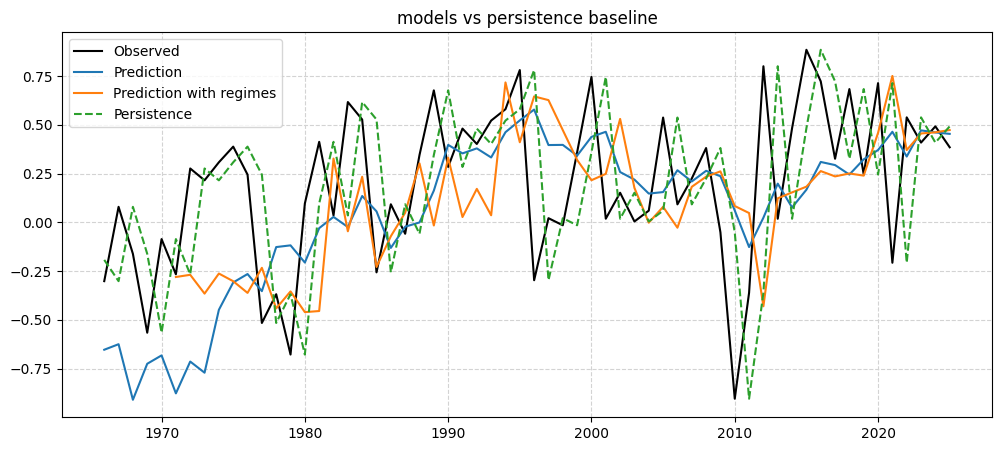

In [349]:
predictions["persistence"] = winter_nao.shift(1).loc[predictions.index]

plt.figure(figsize=(12, 5))
plt.plot(predictions.index, predictions["y_true"], label="Observed", color="black")
plt.plot(predictions.index, predictions["y_pred"], label="Prediction")
plt.plot(predictions_regimes.index, predictions_regimes["y_pred"], label="Prediction with regimes")

plt.plot(predictions.index, predictions["persistence"], label="Persistence", ls="--")


plt.legend()
plt.title("models vs persistence baseline")
plt.grid(linestyle = '--', color = 'lightgrey')
plt.show()


In [350]:
R_ml_regimes = predictions_regimes["y_true"].corr(predictions_regimes["y_pred"])
R_ml = predictions["y_true"].corr(predictions["y_pred"])

R_persist = predictions["y_true"].corr(predictions["persistence"])

print("R² ML, with regimes =", R_ml_regimes**2)
print("R² ML, without regimes =", R_ml**2)
print("R² persistence =", R_persist**2)

R² ML, with regimes = 0.03243526752693586
R² ML, without regimes = 0.15963836475577659
R² persistence = 0.1084178514082077


The Correlation of the model with included regimes is actually lower, so no improvement is seen...

In [351]:


# Evaluate the baseline model

def anomaly_correlation(observed, predicted):
    """
    Compute Anomaly Correlation Coefficient (ACC)
    """
    return np.corrcoef(observed, predicted)[0, 1]
# Convert predictions to numpy arrays
predictions_regimes["y_pred"] = np.array(predictions_regimes["y_pred"])
predictions_withoutregimes = np.array(predictions["y_pred"])

# Error metrics
rmse_regimes = np.sqrt(mean_squared_error(predictions_regimes["y_true"], predictions_regimes["y_pred"]))
rmse_withoutregimes = np.sqrt(mean_squared_error(predictions["y_true"], predictions["y_pred"]))

mse_regimes = rmse_regimes ** 2
mse_withoutregimes = rmse_withoutregimes ** 2
# Skill metrics
acc_regimes = anomaly_correlation(predictions_regimes["y_true"], predictions_regimes["y_pred"])
acc_withoutregimes = anomaly_correlation(predictions["y_true"], predictions["y_pred"])

print("=" * 35)
print("FINAL EVALUATION RESULTS")
print("=" * 35)
print(f"MSE  (regimes): {mse_regimes:.4f}")
print(f"MSE  (reduced):      {mse_withoutregimes:.4f}")
print(f"RMSE (regimes): {rmse_regimes:.4f}")
print(f"RMSE (reduced):      {rmse_withoutregimes:.4f}")
print(f"ACC  (regimes): {acc_regimes:.4f}")
print(f"ACC  (reduced):      {acc_withoutregimes:.4f}")



FINAL EVALUATION RESULTS
MSE  (regimes): 0.2164
MSE  (reduced):      0.2024
RMSE (regimes): 0.4651
RMSE (reduced):      0.4498
ACC  (regimes): 0.1801
ACC  (reduced):      0.3995


Most of the predictable signal in winter NAO is already captured by low-frequency memory and autumn mean circulation.

In [352]:
stats_text = (
    f"MSE  (with regimes):    {mse_regimes:.3f}\n"
    f"MSE  (reduced):      {mse_withoutregimes:.3f}\n"
    f"RMSE (with regimes):   {rmse_regimes:.3f}\n"
    f"RMSE (reduced):     {rmse_withoutregimes:.3f}\n"
    f"ACC  (with regimes):   {acc_regimes:.3f}\n"
    f"ACC  (reduced):     {acc_withoutregimes:.3f}\n"
    f"R^2 ML (with reg.):  {R_ml_regimes**2:.3f}\n"
    f"R^2 ML (reduced):    {R_ml**2:.3f}\n"
    f"R^2 persistence:     {R_persist**2:.3f}"
)
# The original 'features_used' was a list of DataFrames/Series.
# To get a string of feature names, we can use X.columns which contains all feature names.
feature_str = ", ".join(X.columns)


In [353]:
predictions.index[-1]

np.int32(2025)

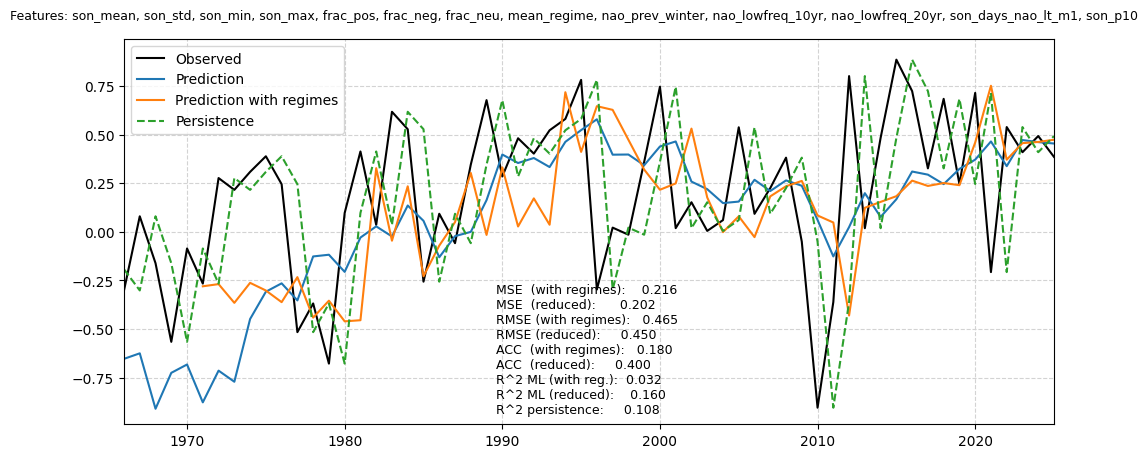

In [354]:
predictions["persistence"] = winter_nao.shift(1).loc[predictions.index]

plt.figure(figsize=(12, 5))
plt.plot(predictions.index, predictions["y_true"], label="Observed", color="black")
plt.plot(predictions.index, predictions["y_pred"], label="Prediction")
plt.plot(predictions_regimes.index, predictions_regimes["y_pred"], label="Prediction with regimes")

plt.plot(predictions.index, predictions["persistence"], label="Persistence", ls="--")
# Add text box
plt.text(
    0.4, 0.02, stats_text,
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment="bottom",
)

plt.legend()
#plt.title("models vs persistence baseline")
plt.suptitle(
    f"Features: {feature_str}",
    fontsize=9,
    y=0.94
)
plt.xlim(1966, 2025)
plt.ylim(-0.99,0.99)
plt.grid(linestyle = '--', color = 'lightgrey')
plt.show()


In [355]:
coefs = model.named_steps["ridge"].coef_
features = X.columns

pd.Series(coefs, index=features).sort_values()

,0
son_mean,-0.134896
nao_lowfreq_20yr,-0.084254
son_p10,-0.016224
frac_neu,-0.008785
frac_neg,-0.006397
son_std,0.005756
mean_regime,0.015971
frac_pos,0.020106
nao_prev_winter,0.041232
son_max,0.056215


In [356]:
coef_df = pd.DataFrame(coefs, columns=X.columns)

summary = pd.DataFrame({
    "mean": coef_df.mean(),
    "std": coef_df.std()
})

summary["stability_ratio"] = summary["std"] / summary["mean"].abs()
summary.sort_values("stability_ratio", ascending=False)

ValueError: Shape of passed values is (13, 1), indices imply (13, 13)

This tells us that the low frequencie is most important.

Also:Improve low-frequency estimation

try 15–20 year filter

Refine extreme metrics

number of NAO < −1 days in SON (daily data)

Add external predictors

stratospheric vortex strength

ENSO / QBO

## Todo:
do real evaluation \
compare to basline sarima version

# Now try ARIMAX as a more complex comparison

In [357]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# ---- Prepare predictors and target ----
X = pd.concat([
    lowfreq,
    son_features['son_min'],
    prev_winter,
    son_features['son_mean']
], axis=1)

y = winter_nao

# Align and drop missing years
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns="nao_djf")
y = data["nao_djf"]

# ---- Standardize predictors ----
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ---- Time series cross-validation ----
tscv = TimeSeriesSplit(n_splits=5)
predictions_ARIMAX = []

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit ARIMAX: here we choose (p,d,q) = (1,0,0) as example; no seasonal term
    # You can tune p,d,q based on AIC/BIC
    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(1,0,0),       # AR(1) model
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False)

    # Use get_forecast for out-of-sample prediction, which is more robust
    forecast_result = model_fit.get_forecast(steps=len(y_test), exog=X_test)
    y_pred = forecast_result.predicted_mean

    # Ensure the predicted values have the same index as y_test for comparison
    y_pred.index = y_test.index

    pred_df = pd.DataFrame({
        "y_true": y_test,
        "y_pred": y_pred
    }, index=y_test.index)

    predictions_ARIMAX.append(pred_df)

predictions_ARIMAX = pd.concat(predictions_ARIMAX).sort_index()


## Evaluation Metrics ARIMAX and Comparative Analysis ARIMAX

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [358]:
# Convert predictions to numpy arrays
predictions_ARIMAX["y_pred"] = np.array(predictions_ARIMAX["y_pred"])

# Error metrics
rmse_ARIMAX = np.sqrt(mean_squared_error(predictions_ARIMAX["y_true"], predictions_ARIMAX["y_pred"]))

mse_ARIMAX = rmse_ARIMAX ** 2
# Skill metrics
acc_ARIMAX = anomaly_correlation(predictions_ARIMAX["y_true"], predictions_ARIMAX["y_pred"])

R_ml_ARIMAX = predictions_ARIMAX["y_true"].corr(predictions_ARIMAX["y_pred"])

In [359]:
stats_text_ARIMAX = (
    f"MSE  (ARIMAX):    {mse_ARIMAX:.3f}\n"

    f"RMSE (ARIMAX):   {rmse_ARIMAX:.3f}\n"

    f"ACC  (ARIMAX):   {acc_ARIMAX:.3f}\n"

    f"R^2 ML (ARIMAX):  {R_ml_ARIMAX**2:.3f}\n"
)
# The original 'features_used' was a list of DataFrames/Series.
# To get a string of feature names, we can use X.columns which contains all feature names.
feature_str = ", ".join(X.columns)

In [363]:
print(stats_text_ARIMAX)

MSE  (ARIMAX):    0.529
RMSE (ARIMAX):   0.727
ACC  (ARIMAX):   0.456
R^2 ML (ARIMAX):  0.208



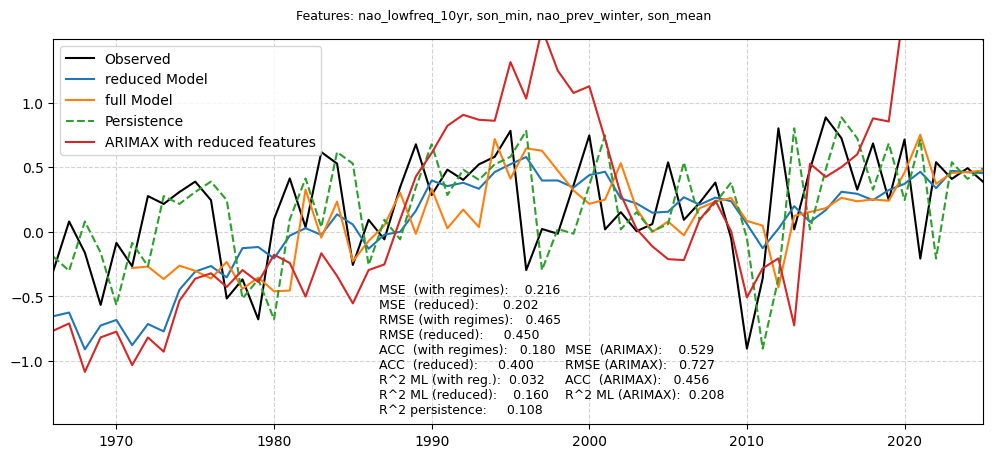

In [365]:
predictions["persistence"] = winter_nao.shift(1).loc[predictions.index]

plt.figure(figsize=(12, 5))
plt.plot(predictions.index, predictions["y_true"], label="Observed", color="black")
plt.plot(predictions.index, predictions["y_pred"], label="reduced Model")
plt.plot(predictions_regimes.index, predictions_regimes["y_pred"], label="full Model")

plt.plot(predictions.index, predictions["persistence"], label="Persistence", ls="--")

plt.plot(predictions_ARIMAX.index, predictions_ARIMAX["y_pred"], label="ARIMAX with reduced features")

# Add text box
plt.text(
    0.35, 0.02, stats_text,
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment="bottom",
)
#additional ARIMAX evaluation
plt.text(
    0.55, 0.02, stats_text_ARIMAX,
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment="bottom",
)

plt.legend()
#plt.title("models vs persistence baseline")
plt.suptitle(
    f"Features: {feature_str}",
    fontsize=9,
    y=0.94
)
plt.xlim(1966, 2025)
plt.ylim(-1.49,1.49)
plt.grid(linestyle = '--', color = 'lightgrey')
plt.show()

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


No extensive hyperparameter tuning was done.

Ridge: alpha fixed at 1.0 → robust, avoids overfitting.

ARIMAX: AR(1) selected → matches weak persistence in NAO.

Reason: small sample size, risk of overfitting, interpretability prioritized.

Todo: \
Ridge: tune carefully alpha=1.0 (Larger alpha → more shrinkage → less variance but more bias, Smaller alpha → less shrinkage → more flexibility but risk of overfitting)\
ARIMAX: p=0..2, q=0..1

In [ ]:
# Implement hyperparameter tuning
# Example using GridSearchCV with a DecisionTreeClassifier
# param_grid = {'max_depth': [2, 4, 6, 8]}
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [ ]:
# Implement the final model(s)
# Example: model = YourChosenModel(best_hyperparameters)
# model.fit(X_train, y_train)


## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [ ]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# Example for regression
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [ ]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
